In [1]:
import pickle 
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import set_matplotlib_formats
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import matplotlib as mpl
from matplotlib import rc

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from fairsoft_utils import formal_fairness_name, formal_metric_name, formal_model_name

In [2]:
def remove_slash_in_dict_keys(a_dict):
    keys = list(a_dict.keys())
    for key in keys:
        a_dict[key.replace('-', '')] = a_dict[key]
        del a_dict[key]
    

In [3]:
def extract_valid_replication(dataset, reg_norm, gamma_list=[0.1, 1., 10, 100, 500, 1000, 5000], perform_metric='HA', target_label_idx=0, masked=False):

    # prefix = f'inprocess/evaluation-{dataset}/evaluation-{target_label_idx}'
    prefix = f'new_fair_through_distance/model/{dataset}/evaluation-{target_label_idx}'
    if masked: 
        prefix += '_masked'
    
    results_gamma = {}
#     perform_gamma = {}
    for gamma in gamma_list:
        
        fair_metrics = []
        fair_results = {}
        for i in range(1, 11):
            target_file = f'{prefix}/fair_eval_{reg_norm}_reg_lambda={gamma:.2f}_{i:04d}.pkl'
            if os.path.exists(target_file):
                fairs = pickle.load(open(target_file, 'rb'))
                
                if '-' in list(fairs.keys())[0]:
                    remove_slash_in_dict_keys(fairs)
                    pickle.dump(fairs, open(target_file, 'wb'))
                
                if not fair_metrics:
                    fair_metrics = list(fairs.keys())

                for met in fairs:
                    if met not in fair_results:
                        fair_results[met] = {}
                    for mod in fairs[met]:
                        if mod not in fair_results[met]:
                            fair_results[met][mod] = []
                        fair_results[met][mod].append(fairs[met][mod])
        
        perform_metrics = []
        perform_results = {}
        for i in range(1, 10):
            target_file = f'{prefix}/perform_eval_{reg_norm}_reg_lambda={gamma:.2f}_{i:04d}.pkl'
            if os.path.exists(target_file):
                performs = pickle.load(open(target_file, 'rb'))
                
                if '-' in list(performs.keys())[0]:
                    remove_slash_in_dict_keys(performs)
                    pickle.dump(performs, open(target_file, 'wb'))
                    
                perform_models = list(performs.keys())
#                 print(perform_models)
                if not perform_metrics:
                    perform_metrics = list(performs[perform_models[0]].keys())
#                 print(perform_metrics)
                for met in perform_metrics:
                    if met not in perform_results:
                        perform_results[met] =  {}
                    for mod in performs:
                        if mod not in perform_results[met]:
                            perform_results[met][mod] = []

                        perform_results[met][mod].append(performs[mod][met])

        fair_metrics = list(fair_results.keys())
        fair_metrics_nested = {}
        fair_metrics_sorted = []
        should_add_eo = False
        for met_hparam in fair_metrics:
            met = met_hparam.split('_')[0]
            if met not in fair_metrics_nested:
                fair_metrics_nested[met] = []
            fair_metrics_nested[met].append(met_hparam)
        
        for met in ['constant', 'jaccard', 'indication', 'elementwise']:
            if met in fair_metrics_nested:
                if len(fair_metrics_nested[met]) > 1:
                    met_sorted = sorted(
                        fair_metrics_nested[met], key=lambda met: float(met.split('_')[-1]))
                else:
                    met_sorted = fair_metrics_nested[met]
                fair_metrics_sorted += met_sorted
        fair_metrics = fair_metrics_sorted
    
        for met in fair_metrics:
            if met not in results_gamma:
                results_gamma[met] = {}
            
            result = []
            for mod in fair_metrics + ['unfair']:
                if mod not in results_gamma[met]:
                    results_gamma[met][mod] = []
                
                results = fair_results[met][mod]
                fair_mean = np.mean(results, 0)[0]
                fair_se = np.std(results, 0)[0] / np.sqrt(len(results))

                results = perform_results[perform_metric][mod]
                perform_mean = np.mean(results, 0)[0]
                perform_se = np.std(results, 0)[0] / np.sqrt(len(results))
                results_gamma[met][mod].append([fair_mean, perform_mean])
    
    for met in results_gamma:
        for mod in results_gamma[met]:
            results_gamma[met][mod] = np.array(results_gamma[met][mod])
            if len(results_gamma[met][mod]) != len(gamma_list):
                print(f'Incomplete trial on: [metric={met}], [model={mod}], '\
                      f'trial: [found={len(results_gamma[met][mod])}], [expected={len(gamma_list)}]')
                
    return results_gamma

In [4]:
def _model_name_sort(a, b):
    if ('SF' in a or 'SimFair' in a) and ('SF' in b or 'SimFair' in b):
        gamma_a = a.replace('{', '').replace('}', '').split('_')[1].split(' ')[1]
        gamma_b = b.replace('{', '').replace('}', '').split('_')[1].split(' ')[1]
#         print(a.replace('{', '').replace('}', ''), gamma_b)
        if float(gamma_a) > float(gamma_b):
            return 1
        else:
            return -1        
    elif ('SF' in a or 'SimFair' in a):
        return -1
    elif ('SF' in b or 'SimFair' in b):
        return 1
    elif a > b:
        return 1
    else:
        return -1
        

from functools import cmp_to_key
model_name_sort = cmp_to_key(_model_name_sort)

In [8]:
def plot_tradeoff(results_all, dataset, fair_metric, perform_metric):  
    fontsize = 13

    fair_notion = formal_fairness_name(fair_metric)
    safe_colors = ['#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD', '#000000']
    
    jac_colors = {}
    for jac in ['jaccard_0.01', 'jaccard_1.0', 'jaccard_5.0', 'jaccard_10.0']:
        jac_colors[jac] = safe_colors[len(jac_colors) + 1]
    
    base_colors = {'constant': 'red', 'indication': 'green', 'unfair': 'blue', 'elementwise': 'orange'}
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    for ax, perform_metric in zip(axes, perform_metric):
        
        results = results_all[perform_metric]
        target = results[fair_metric]
#         print(target)
        perform_metric = formal_metric_name(perform_metric)

        keys = {formal_model_name(key):key for key in target.keys()}
        keys_sort = list(keys.keys())
#         print(keys_sort)
        keys_sort.sort(key=model_name_sort)
        # print(keys_sort)
        for key in keys_sort:
            key = keys[key]
            x, y = target[key][:, 0], target[key][:, 1]
            model_name = formal_model_name(key)
            model_name = model_name.replace('.0 ', '')
            
            if key != 'elementwise':
                if key in ['constant', 'indication', 'unfair']:
                    color = base_colors[key]
                    zorder = -1
                    linewidth = 3
                    linestyle = 'solid'
                    marker = 'o'
                else:
                    color = jac_colors[key]
                    zorder = 1
                    linewidth= 3
                    linestyle = 'dotted'
                    marker = '1'
                ax.plot(x, y, linestyle=linestyle, linewidth=linewidth, marker=marker, label=model_name, color=color, zorder=zorder) 

        # legends = model_names
        handles, labels = ax.get_legend_handles_labels()
        ax.tick_params(direction='in', pad=20, left=True, right=True, top=True, bottom=True)
        ax.grid('on', ls='dotted')
#         ax.autoscale(False)
#         ax.set_xscale('log')
        if dataset == 'adult':
            ax.set_ylabel(f'{perform_metric}: Adult dataset', fontsize=fontsize)    
        else:
            ax.set_ylabel(f'{perform_metric}: German dataset', fontsize=fontsize)
        ax.yaxis.set_label_coords(-0.18,0.5)
        
        ax.tick_params(axis='x', rotation=70, pad=1)
        ax.set_xlabel(fr'Fairness violation: {fair_notion}', fontsize=fontsize)
        start, end = ax.get_xlim()
        ax.set_xlim(start, end)
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())

    fig.legend(loc='upper center', labels=labels, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=4, fontsize=fontsize)
    plt.tight_layout()

    

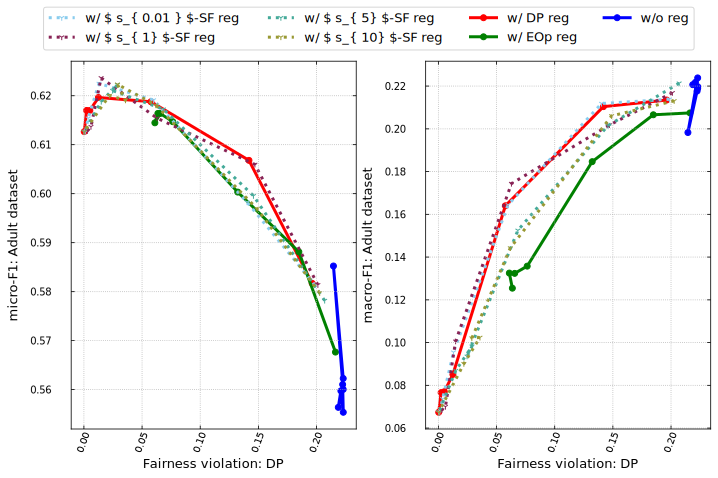

In [9]:
dataset = 'adult'
fairnotion = 'constant'
perform_metric = ['miF1', 'maF1']
results_all = {}
for perform in perform_metric:
    results_all[perform] = extract_valid_replication(dataset, 'l2', perform_metric=perform, masked=False)
plot_tradeoff(results_all, dataset, fairnotion, perform_metric)

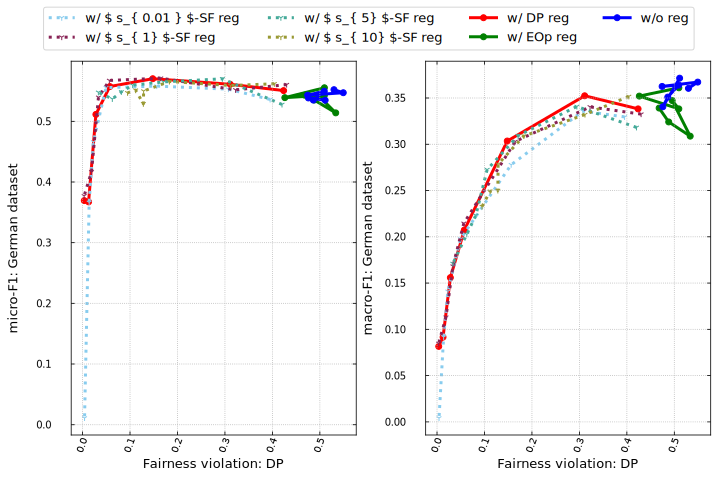

In [10]:
dataset = 'credit'
fairnotion = 'constant'
perform_metric = ['miF1', 'maF1']
results_all = {}
for perform in perform_metric:
    results_all[perform] = extract_valid_replication(dataset, 'l2', perform_metric=perform, masked=False)
plot_tradeoff(results_all, dataset, fairnotion, perform_metric)